In [13]:
import torch
import numpy as np
import pandas as pd
from torch import nn
import yfinance as yf
from scipy import stats
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns
import arch
from arch import arch_model
from scipy.stats import norm
import matplotlib.dates as mdates

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

## Download data from Yahoo Finance

Text(0.5, 0, 'Date')

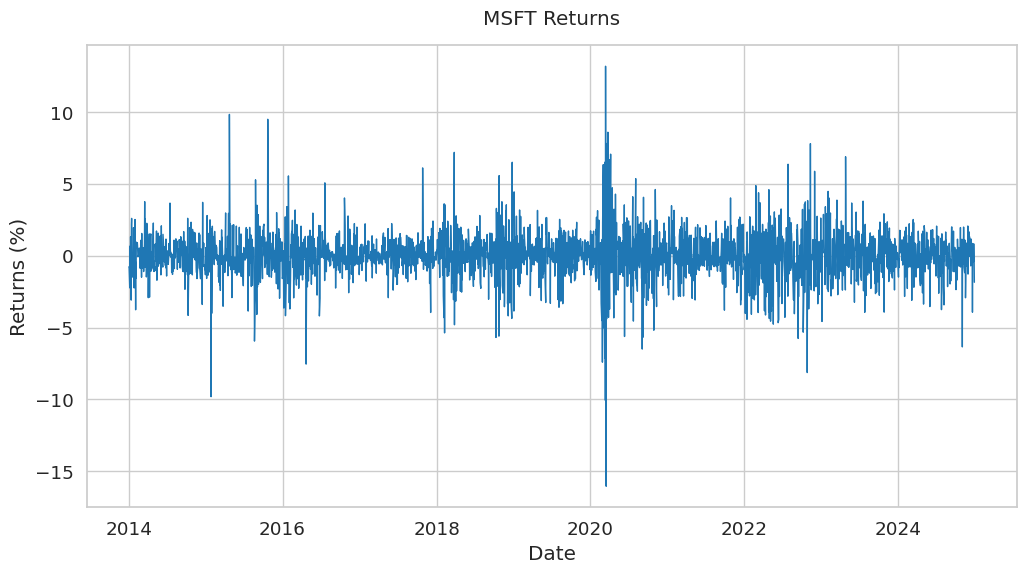

In [52]:
""" download data """
ric = 'MSFT'
ticker = yf.Ticker(ric)
hist = ticker.history(period="max")

""" log return """
ret = np.log(hist['Close']).diff().dropna()*1e2

""" split data into train/val/test """
train_start_date = pd.Timestamp('2014-01-01', tz=hist.index.tz)
val_start_date = pd.Timestamp('2020-01-01', tz=hist.index.tz) 
test_start_date = pd.Timestamp('2022-01-01', tz=hist.index.tz)
test_end_date = pd.Timestamp('2024-01-01', tz=hist.index.tz)  

""" demean """
ret = ret - ret[train_start_date:val_start_date].mean()
ret = ret[train_start_date:]

""" prepare data for GARCH model """
x = ret.iloc[:-1]  # lagged returns
y = ret.iloc[1:]   # returns to predict
train_size = x[train_start_date:val_start_date].shape[0]
val_size = x[val_start_date:test_start_date].shape[0]
test_size = x[test_start_date:].shape[0]

""" plot return series to visualize volatility clustering """
plt.figure(figsize=(12, 6))
sns.lineplot(data=ret, linewidth=1)
plt.title(f'{ric} Returns', pad=15)
plt.ylabel('Returns (%)')
plt.xlabel('Date')

# Available tickers from Yahoo Finance:
# Indices: ^GSPC (S&P 500), ^DJI (Dow), ^IXIC (Nasdaq)
# Tech: AAPL, MSFT, GOOG, META, NVDA, AMD, INTC
# Finance: JPM, BAC, V, MA, PYPL
# Others: NFLX, AMZN, BABA

## Fit a GARCH model

In [53]:
""" fit a GARCH model for individual stock """
am = arch_model(x, p=1, o=0, q=1, dist='Normal', mean='Zero', vol='GARCH')
res = am.fit(disp='off', first_obs=0, last_obs=train_size+val_size)

""" initialize forecast dataframe """
gc_fc = pd.DataFrame(index=x.index, columns=['h.1'])

""" forecast for all dates """
fc_all = res.forecast(start=0, horizon=1, reindex=False).variance**0.5
gc_fc.iloc[:train_size+val_size] = fc_all[:train_size+val_size].values

""" re-estimate and forecast for testing period """
for i in range(train_size+val_size, len(x)):
    # Fit model up to current point
    res = am.fit(disp='off', first_obs=0, last_obs=i)
    # Make one-step ahead forecast
    fc_temp = res.forecast(start=i, horizon=1, reindex=False).variance**0.5
    gc_fc.iloc[i] = fc_temp.values[0]

display(gc_fc)

,h.1
Date,
2014-01-02 00:00:00-05:00,1.43328
2014-01-03 00:00:00-05:00,1.352077
2014-01-06 00:00:00-05:00,1.601648
2014-01-07 00:00:00-05:00,1.468189
2014-01-08 00:00:00-05:00,1.5856
...,...
2024-12-19 00:00:00-05:00,1.719789
2024-12-20 00:00:00-05:00,1.585804
2024-12-23 00:00:00-05:00,1.481443


## Load and Forecast with DeepVol

In [54]:
class LSTM(nn.Module):
    def __init__(self, d_in=1, hidden_size=10, num_layers=1, dropout=0.2, **kwargs):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=d_in,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.softplus = nn.Softplus()

    def forward(self, x):  # x shape: (batch_size, seq_len, d_in)
        output, _ = self.lstm(x)
        output = self.fc(output)
        return self.softplus(output) + 1e-6
    
deepvol = LSTM()
deepvol.load_state_dict(torch.load('checkpoint.pt', weights_only=True))

<All keys matched successfully>

In [55]:
""" simply pass the input to DeepVol """
deepvol.eval()
with torch.no_grad():
    dp_fc = deepvol(torch.tensor(x.values).float().unsqueeze(1)).numpy()**0.5

# Evaluation

## Compare Risk Metrics

In [56]:
""" risk metrics """
def qn(p):
    return stats.norm.ppf(p) 

def esn(p): 
    ninv = stats.norm.ppf(p)
    return -stats.norm.pdf(ninv) / p 

def qloss_fn(var, r, p):
    x1 = r[r > var]
    x2 = r[r < var]
    f1 = var[r > var]
    f2 = var[r < var]
    return (p * np.sum(x1-f1) + (1-p) * np.sum(f2-x2))/len(r)

def jloss_fn(es, var, r, p):
    i1 = (r < var).astype(int)
    aes = es ** (-1) * (p-1)
    ees = (r-var) * (p - i1)
    l =  np.sum(-np.log(aes)) - np.sum(ees / es) / p
    return l/len(r)

def nll_fn(h, r):
    return -stats.norm.logpdf(r, loc=0., scale=h).mean()

def risk_metric(h, r, p, mu=0.):
    var = qn(p) * h + mu
    es = esn(p) * h + mu
    qloss = qloss_fn(var, r, p)
    jloss = jloss_fn(es, var, r, p)
    nll = nll_fn(h, r)
    return qloss, jloss, nll

In [57]:
alpha = 0.01
qloss_garch, jloss_garch, nll_garch = risk_metric(gc_fc.to_numpy(dtype=np.float32).squeeze()[train_size+val_size:], y.to_numpy(dtype=np.float32).squeeze()[train_size+val_size:], alpha)
qloss_dp, jloss_dp, nll_dp = risk_metric(dp_fc.squeeze()[train_size+val_size:], y.to_numpy(dtype=np.float32).squeeze()[train_size+val_size:], alpha)
print(f'GARCH: \n Quantile Loss: {qloss_garch:.4f}, Joint Loss: {jloss_garch:.4f}, NLL: {nll_garch:.4f}')
print(f'DeepVol: \n Quantile Loss: {qloss_dp:.4f}, Joint Loss: {jloss_dp:.4f}, NLL: {nll_dp:.4f}')

GARCH: 
 Quantile Loss: 0.0667, Joint Loss: 3.0913, NLL: 1.9649
DeepVol: 
 Quantile Loss: 0.0594, Joint Loss: 2.8765, NLL: 1.9408


# News impact curve

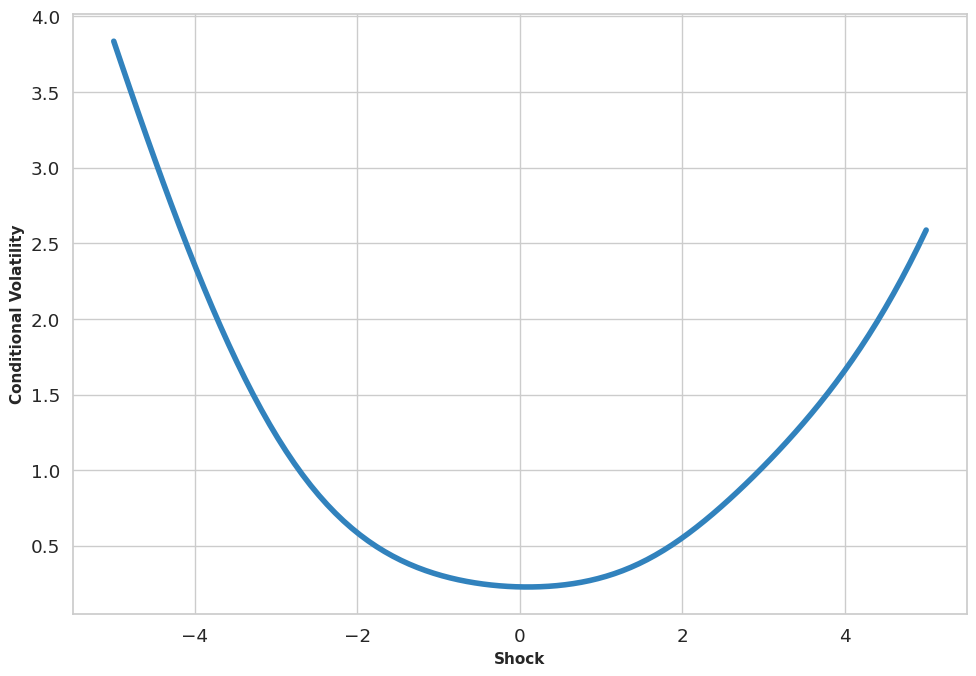

In [58]:
seq_len = 126
num_shocks = 100
shock_range = 5
baseline_sequence = np.zeros((seq_len, 1))
device = torch.device('cpu')

shocks = np.linspace(-shock_range, shock_range, num_shocks)
sequences = np.tile(baseline_sequence, (num_shocks, 1, 1))
sequences[:, -1, 0] = shocks
sequences_tensor = torch.tensor(sequences, dtype=torch.float32)

deepvol.eval()
with torch.no_grad():
    news_impact = deepvol(sequences_tensor)[:, -1].numpy().flatten()

plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
sns.lineplot(x=shocks, y=news_impact, color='#3182bd', linewidth=4)
plt.xlabel("Shock", fontsize=11, fontweight='bold')
plt.ylabel("Conditional Volatility", fontsize=11, fontweight='bold')
plt.tight_layout()

# Response to outliers

In [59]:
""" Make forecast for with and without outliers """

# Without outliers
deepvol.eval()
with torch.no_grad():
    dp_variance = deepvol(torch.tensor(x.values).float().unsqueeze(1)).numpy().squeeze()

# Fit GARCH(1,1) model
garch_model = arch_model(x, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off', last_obs=train_size + val_size)
garch_forecast = garch_result.forecast(start=0)
garch_variance = garch_forecast.variance.values.flatten()

# Calculate 1% ES for DeepVol and GARCH
dp_es_1 = -norm.pdf(norm.ppf(0.01)) / 0.01 * np.sqrt(dp_variance)
garch_es_1 = -norm.pdf(norm.ppf(0.01)) / 0.01 * np.sqrt(garch_variance)

# With outliers
x_outlier = x.copy()
y_outlier = y.copy()

outliers = -20
outliers_step = train_size+val_size+375
x_outlier.iloc[outliers_step] = outliers
y_outlier.iloc[outliers_step] = outliers

deepvol.eval()
with torch.no_grad():
    dp_variance_outlier = deepvol(torch.tensor(x_outlier.values).float().unsqueeze(1)).numpy().squeeze()

# Fit GARCH(1,1) model
garch_model = arch_model(x_outlier, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off', last_obs=train_size + val_size)
garch_forecast = garch_result.forecast(start=0)
garch_variance_outlier = garch_forecast.variance.values.flatten()

# Calculate 1% ES for DeepVol and GARCH with outliers
dp_es_1_outlier = -norm.pdf(norm.ppf(0.01)) / 0.01 * np.sqrt(dp_variance_outlier)
garch_es_1_outlier = -norm.pdf(norm.ppf(0.01)) / 0.01 * np.sqrt(garch_variance_outlier)

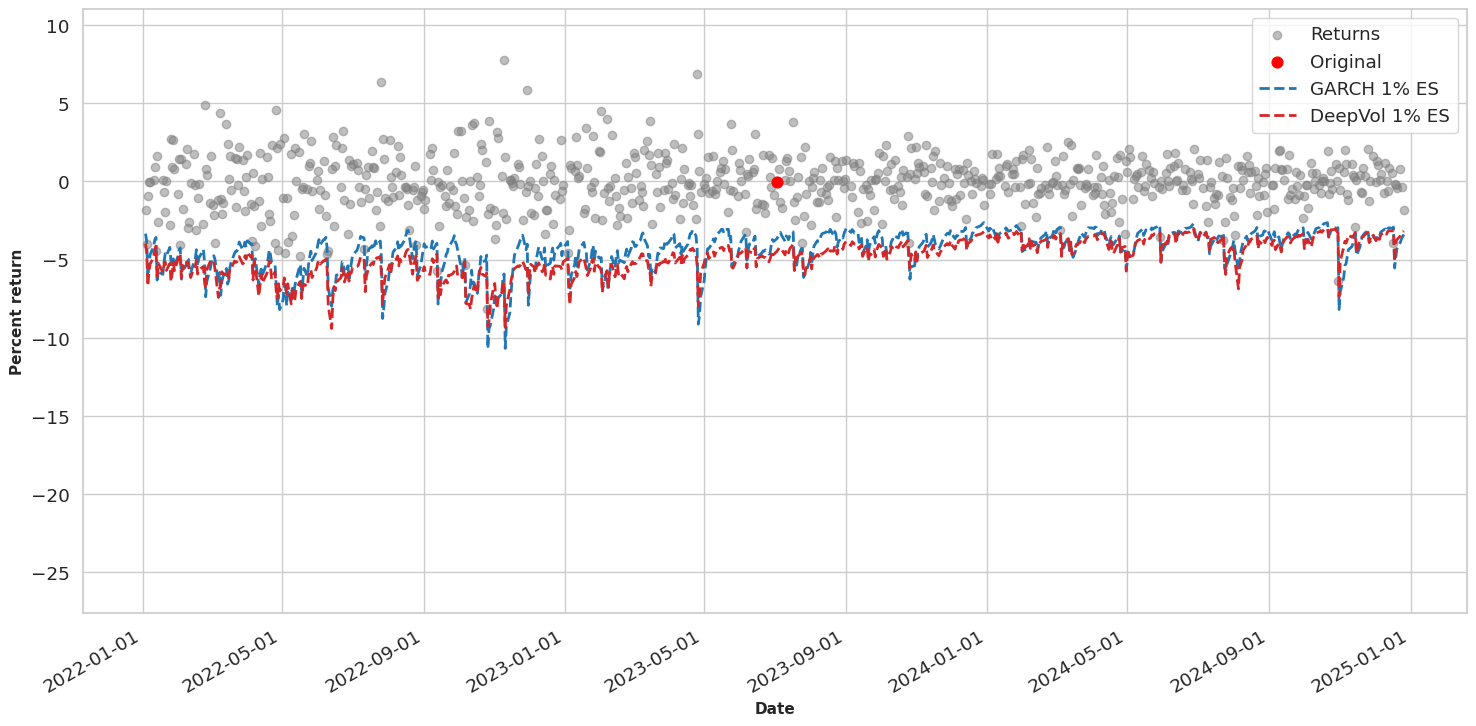

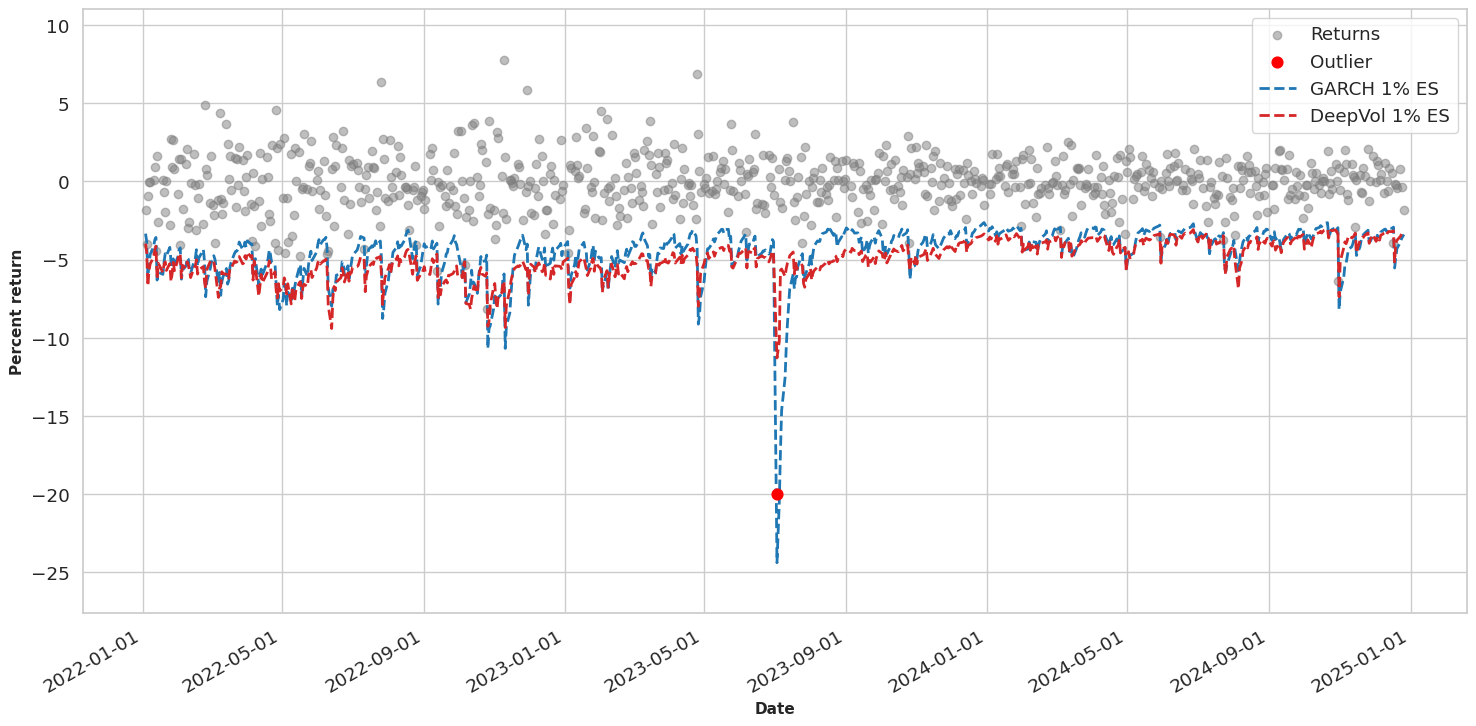

In [60]:
# Plot returns, volatility, and ES for both models (test period only) - Original Data
plt.figure(figsize=(15, 7.5))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Determine y-axis limits for both plots (make sure two plots have the same y-axis limits for better visualization)
y_min = min(min(y[train_size+val_size:]), min(y_outlier[train_size+val_size:]), min(garch_es_1[train_size+val_size:]), min(dp_es_1[train_size+val_size:]),
            min(garch_es_1_outlier[train_size+val_size:]), min(dp_es_1_outlier[train_size+val_size:]))
y_max = max(max(y[train_size+val_size:]), max(y_outlier[train_size+val_size:]), max(garch_es_1[train_size+val_size:]), max(dp_es_1[train_size+val_size:]),
            max(garch_es_1_outlier[train_size+val_size:]), max(dp_es_1_outlier[train_size+val_size:]))

# Add a margin to y_min and y_max to widen the scale
margin = (y_max - y_min) * 0.1
y_min -= margin
y_max += margin

# Get dates for test period
dates = x.index.to_numpy()

# Scatter plot for returns (test period)
plt.scatter(dates[train_size+val_size:], y[train_size+val_size:], alpha=0.5, color='#7f7f7f', label='Returns')

# Highlight the outlier point
plt.scatter(dates[outliers_step], y.iloc[outliers_step], color='red', s=60, zorder=5, label='Original')

# Line plot for GARCH ES forecast (test period)
plt.plot(dates[train_size+val_size:], garch_es_1[train_size+val_size:], color='#1f77b4', linewidth=2, linestyle='--', label='GARCH 1% ES')

# Line plot for DeepVol ES forecast (test period)
plt.plot(dates[train_size+val_size:], dp_es_1[train_size+val_size:], color='#d62728', linewidth=2, linestyle='--', label='DeepVol 1% ES')

plt.xlabel("Date", fontsize=11, fontweight='bold')
plt.ylabel("Percent return", fontsize=11, fontweight='bold')
plt.legend()
plt.ylim(y_min, y_max)  # Set y-axis limits

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

plt.tight_layout()

# Plot returns, volatility, and ES for both models (test period only) - With Outliers
plt.figure(figsize=(15, 7.5))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Scatter plot for returns (test period)
plt.scatter(dates[train_size+val_size:], y_outlier[train_size+val_size:], alpha=0.5, color='#7f7f7f', label='Returns')

# Highlight the outlier
plt.scatter(dates[outliers_step], outliers, color='red', s=60, zorder=5, label='Outlier')

# Line plot for GARCH ES forecast (test period)
plt.plot(dates[train_size+val_size:], garch_es_1_outlier[train_size+val_size:], color='#1f77b4', linewidth=2, linestyle='--', label='GARCH 1% ES')

# Line plot for DeepVol ES forecast (test period)
plt.plot(dates[train_size+val_size:], dp_es_1_outlier[train_size+val_size:], color='#d62728', linewidth=2, linestyle='--', label='DeepVol 1% ES')

plt.xlabel("Date", fontsize=11, fontweight='bold')
plt.ylabel("Percent return", fontsize=11, fontweight='bold')
plt.legend()
plt.ylim(y_min, y_max)  # Set same y-axis limits as first plot

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

plt.tight_layout()
plt.show()